In [8]:
%pip -q install google-genai

In [9]:
# Configura a API Key do Google Gemini

import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [10]:
# Configura o cliente da SDK do Gemini

from google import genai

client = genai.Client()

MODEL_ID = "gemini-2.0-flash"

In [11]:
# Instalar Framework de agentes do Google ################################################
!pip install -q google-adk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.1/232.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.1/334.1 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.

In [12]:
# Configura a API Key do Google Gemini

from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search
from google.genai import types  # Para criar conteúdos (Content e Part)
from datetime import date
import textwrap # Para formatar melhor a saída de texto
from IPython.display import display, Markdown # Para exibir texto formatado no Colab
import requests # Para fazer requisições HTTP
import warnings
from PIL import Image
from io import BytesIO
import base64
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

warnings.filterwarnings("ignore")

In [13]:
# Função auxiliar que envia uma mensagem para um agente via Runner e retorna a resposta final
def call_agent(agent: Agent, message_text: str) -> str:
    # Cria um serviço de sessão em memória
    session_service = InMemorySessionService()
    # Cria uma nova sessão (você pode personalizar os IDs conforme necessário)
    session = session_service.create_session(app_name=agent.name, user_id="user1", session_id="session1")
    # Cria um Runner para o agente
    runner = Runner(agent=agent, app_name=agent.name, session_service=session_service)
    # Cria o conteúdo da mensagem de entrada
    content = types.Content(role="user", parts=[types.Part(text=message_text)])

    final_response = ""
    # Itera assincronamente pelos eventos retornados durante a execução do agente
    for event in runner.run(user_id="user1", session_id="session1", new_message=content):
        if event.is_final_response():
          for part in event.content.parts:
            if part.text is not None:
              final_response += part.text
              final_response += "\n"
    return final_response

In [14]:
from typing import Optional

def generate_media_image(image_description: str) -> Optional[Image.Image]:
    """
    Gera uma imagem para redes sociais usando o modelo Gemini com a descrição fornecida.

    Args:
        image_description: A descrição textual da imagem a ser gerada para o post.

    Returns:
        Um objeto PIL Image da imagem gerada ou None em caso de erro.
    """
    try:
        image_prompt = f"Crie uma imagem vibrante e criativa para realcionada a história: '{image_description}'."
        response = client.models.generate_content(
            model="gemini-2.0-flash-preview-image-generation",
            contents=image_prompt,
            config=types.GenerateContentConfig(
            response_modalities=['TEXT', 'IMAGE']
            )
        )

        for part in response.candidates[0].content.parts:
          if part.text is not None:
            print(part.text)
          elif part.inline_data is not None:
            image = Image.open(BytesIO((part.inline_data.data)))
            image.save('gemini-native-image.png')
            image.show()

    except Exception as e:
        print(f"Ocorreu um erro ao gerar a imagem: {e}")
        return None

In [15]:
# Função auxiliar para exibir texto formatado em Markdown no Colab
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [16]:
##########################################
# --- Agente 1: Criador de histórias --- #
##########################################
def agente_criador(personagem):

    criador = Agent(
        name="agente_criador",
        model="gemini-2.0-flash",
        instruction="""
        Você é um escritor de histórias infantis. Crie histórias bem curtas a partir do personagem informado que sempre termine com uma situação engraçada.
        """,
        description="Criador de histórias infantis",
    )

    entrada_do_agente_criador = f"Tópico: {personagem}\n"

    historia = call_agent(criador, entrada_do_agente_criador)
    return historia

In [17]:
##########################################
# --- Agente 5: Criador de Imagem --- #
##########################################

def agente_criador_imagem(personagem, historia):
    criador = Agent(
        name="agente_criador_imagem",
        model="gemini-2.0-flash",
        instruction="""
            Você é um Criador de Imagens para Redes Sociais, especializado em gerar
            visuais impactantes para posts de Instagram. Com base no texto do post
            revisado fornecido, crie uma descrição detalhada da imagem ideal para
            complementar o conteúdo. Retorne apenas a descrição da imagem que será usada
            no modelo do Gemini para criar uma imagem.
            """,
        description="Agente revisor de post para redes sociais."
    )
    entrada_do_agente_criador = f"Personagem: {personagem}\História: {historia}"
    # Executa o agente
    descricao_imagem = call_agent(criador, entrada_do_agente_criador)
    return descricao_imagem

In [20]:
def generate_media_image(image_description: str) -> Optional[Image.Image]:
    """
    Gera uma imagem para redes sociais usando o modelo Gemini com a descrição fornecida.

    Args:
        image_description: A descrição textual da imagem a ser gerada para o post.

    Returns:
        Um objeto PIL Image da imagem gerada ou None em caso de erro.
    """
    try:
        image_prompt = f"Crie uma imagem vibrante e criativa para realcionada a história: '{image_description}'."
        response = client.models.generate_content(
            model="gemini-2.0-flash-preview-image-generation",
            contents=image_prompt,
            config=types.GenerateContentConfig(
            response_modalities=['TEXT', 'IMAGE']
            )
        )

        generated_image_obj = None # Inicializa a variável para armazenar o objeto da imagem

        for part in response.candidates[0].content.parts:
          if part.text is not None:
            print(part.text)
          elif part.inline_data is not None:
            image = Image.open(BytesIO((part.inline_data.data)))
            image.save('gemini-native-image.png')
            generated_image_obj = image # Armazena o objeto da imagem
            print("Imagem salva como 'gemini-native-image.png'") # Confirma que a imagem foi salva
            # image.show() # Desativei para evitar a janela separada, o display do matplotlib é melhor no Colab


        return generated_image_obj # Retorna o objeto da imagem

    except Exception as e:
        print(f"Ocorreu um erro ao gerar a imagem: {e}")
        return None

🚀 Iniciando o criador de histórias infantis!
❓ De qual personagem gostaria de ter uma história? Pode ser um animal, um objeto ou uma pessoa: pulga
Maravilha! Vamos então criar uma história de pulga
A imagem mostrará uma cena alegre e vibrante: um pequeno campo verde repleto de flores de diversas cores e algumas pedras de rio espalhadas. No centro, uma minúscula pulga chamada Pula-Pula estará no ar, com um sorriso travesso bem visível em seu rosto, como se estivesse aproveitando um salto cheio de energia. Ela estará prestes a aterrissar na careca brilhante de um grande cachorro marrom, que dorme profundamente e tranquilamente sob a sombra de uma árvore com folhas verdes exuberantes. O cachorro terá uma expressão serena, completamente inconsciente da pulga se aproximando. Acima da pulga, a onomatopeia "PIMBA!" será exibida em letras grandes, coloridas e com um estilo divertido, realçando o momento do salto. A iluminação será natural e suave, criando uma atmosfera de diversão e surpresa c

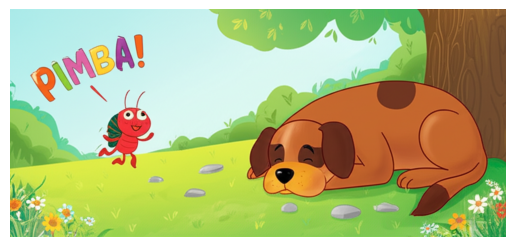

> Era uma vez uma pulguinha chamada Pula-Pula, que adorava saltar. Ela pulava na grama, pulava nas pedras, pulava até nas flores! Um dia, Pula-Pula decidiu que queria pular mais alto do que nunca. Ela se preparou, respirou fundo e... PIMBA! Pulou direto para a careca brilhante de um cachorro dorminhoco. O susto foi tão grande que o cachorro acordou latindo e Pula-Pula saiu rolando, tonta, morrendo de rir! Que pulo engraçado!
> 


In [21]:
print("🚀 Iniciando o criador de histórias infantis!")

# --- Obter o Tópico do Usuário ---
personagem = input("❓ De qual personagem gostaria de ter uma história? Pode ser um animal, um objeto ou uma pessoa: ")

# Inserir lógica do sistema de agentes ################################################
if not personagem:
    print("Você esqueceu de digitar o personagem!")
else:
    print(f"Maravilha! Vamos então criar uma história de {personagem}")

    # Chame agente_criador para gerar a história primeiro
    historia = agente_criador(personagem)

    descricao_imagem = agente_criador_imagem(personagem, historia)

    # Note: The function generate_social_media_image is not defined in the provided code.
    # Assuming the user meant to call generate_media_image
    generated_image = generate_media_image(descricao_imagem)

    # Check if an image was successfully generated before attempting to display it
    if generated_image:
        img = mpimg.imread('gemini-native-image.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    # Call agente_revisor after the story is generated
    # Note: The function agente_revisor is not defined in the provided code.
    # This line may cause a NameError if agente_revisor is not defined elsewhere.
    # If agente_revisor is intended to be used, ensure it is defined.
    # For the purpose of fixing the 'historia' NameError, we assume agente_revisor will be defined.
    # historia = agente_revisor(personagem, historia) # Uncomment if agente_revisor is defined
    # Assuming historia is the final text to be displayed. If agente_revisor modifies it,
    # the display should use the variable after the call to agente_revisor.
    display(to_markdown(historia))